In [1]:
import numpy as np 
import numpy.random as npr
import matplotlib.pyplot as plt 
import scipy.stats as stats 
import scipy.linalg as linalg
from tqdm import tqdm
import time
from scipy.integrate import quad
from gaussian_tails import coupling_gaussian_distributions
np.random.seed(6789)

## Notations 

Toutes les variables aléatoires sont définies sur un espace de probabilité $ (\Omega, \mathcal{F}, \mathbb{P}) $ et prennent leurs valeurs dans un espace mesurable $ \mathbb{X} $ qui est $ \mathbb{Z} $ ou $ \mathbb{R} ^d $. 

- $ X \sim p $ : $X $ admet une densité par rapport à la mesure de Lebesgue ou de comptage. 

- $ Y \sim q $

- $ \frac{ d \mathbb{P} _{(X,Y)}}{d \lambda} := \Gamma $

- $ U_n \sim V_n $ ssi $ \frac{U_n}{V_n} \to 1 $ quand $n \to + \infty $

## Plan 

- ##### Introduction 

- ##### Méthode d'échantillonnage par rejet couplé, suivi d'un exemple

- ##### Algorithme de Reflexion Coupling

- ##### Application 1 : Liaison des queues des distributions gaussiennes

- ##### Applicatio 3 : Coupled Gibbs sampling

- ##### Algorithme de Thorisson 

## Introduction 

Si $(X_t)_t$ et $(Y_t)_t$ sont des chaînes de Markov, le temps de couplage est défini comme : $\text{inf} \{t \ge 0 : X_t = Y_t \}$. 

On propose une illustration à partir de [l'article](https://proceedings.mlr.press/v130/wang21d/wang21d.pdf) de O’Leary, Wang et Jacob. 

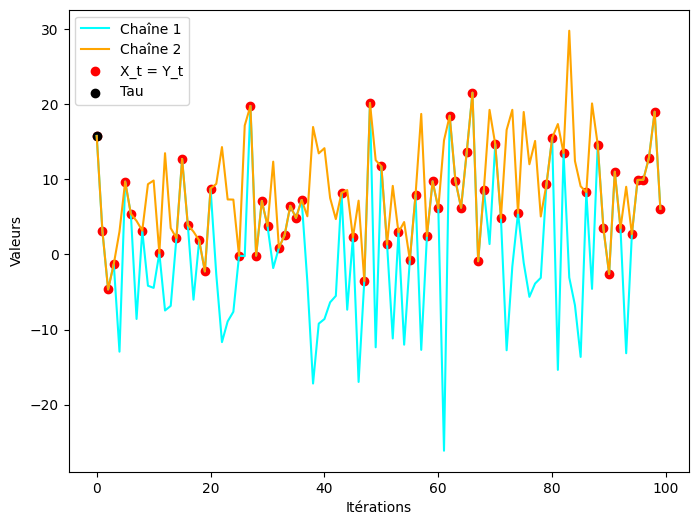

In [6]:
def algorithm2(values, length):
    def normal_mean(value, evaluate):
        """  Densité d'une loi normale de moyenne value et de variance 10, évaluée en evaluate      
        """
        return np.exp(-(evaluate - value)**2 / 20) / (np.sqrt(20 * np.pi))
    simulation = []

    for i in range(length):
        x2, U = npr.normal(values[0], 10), npr.uniform()
        rapport = normal_mean(values[1], x2) / normal_mean(values[0], x2)
        if U <= rapport: 
            y2 = x2
        else: 
            repeat = True 
            while repeat: 
                y3, V = npr.normal(values[1], 10), npr.uniform()
                rapport = normal_mean(values[0], y3) / normal_mean(values[1], y3)
                if rapport <= V: 
                    y2 = y3
                    repeat = False
        simulation.append([i, x2, y2])
    return np.array(simulation) 

simulation = algorithm2(np.array([0.25, 4]), 10**2)
plt.figure(figsize=(8,6))
plt.plot(simulation[:,0], simulation[:,1], label = "Chaîne 1", color = "cyan")
plt.plot(simulation[:,0], simulation[:,2], label = "Chaîne 2", color = 'orange')
plt.scatter(simulation[simulation[:,1] == simulation[:,2]][:,0], simulation[simulation[:,1] == simulation[:,2]][:,1], color='red', label="X_t = Y_t")
plt.scatter(simulation[simulation[:,1] == simulation[:,2]][0,0],simulation[simulation[:,1] == simulation[:,2]][0,1], color='black', label="Tau")
plt.plot()
plt.xlabel("Itérations")
plt.ylabel("Valeurs")
plt.legend()
plt.show()

## Méthode d'échantillonnage par rejet couplé

$\textbf{Definition 1}$ : Un couple de variables aléatoires $ (X, Y)$ défini sur le même espace de probabilité et prenant ses valeurs dans $ \mathcal{X} $ est un couplage diagonal de probabilités $p$ et $q$ si, et seulement si, c'est un couplage tel que : 

- $ \mathbb{P} (X \in A) = \displaystyle \int _{A} p(x) dx $ 

- $ \mathbb{P} (Y \in A) = \displaystyle \int _{A} q(x) dx $, $ \forall A \subset \mathcal{X}$ 

- $ \mathbb{P} (X = Y) > 0$

Avec cette définition, un couplage maximal est un couplage diagonal de masse maximale sur l'évènement $ \{ X = Y \}$. 


$\textbf{Definition 2}$ : Soient $( \hat{p}, \hat{q}) $ une paire de densités de probabilité. On dit que $( \hat{p}, \hat{q}) $ domine $ (p,q) $ ou on écrit $( \hat{p}, \hat{q}) \succeq ( \hat{p}, \hat{q}) $ ssi il existe $ 1 \le M(p, \hat{p}) < + \infty$ , $ 1 \le M(q, \hat{q}) < + \infty$ tel que $ \forall x \in \mathbb{R} ^d$ on ait : $ p(x) \le M(p, \hat{p}) \hat{p} (x) $ , $ q(x) \le M(q, \hat{q}) \hat{q} (x) $.

Attention ! Ce n'est pas parce que nous avons de tels $( \hat{p}, \hat{q}) \succeq ( \hat{p}, \hat{q}) $ que $ \hat{ \Gamma } \succeq \Gamma $. 


Supposons que nous disposons de tels $( \hat{p}, \hat{q}) \succeq ( \hat{p}, \hat{q}) $ et de  $\hat{ \Gamma } \succeq \Gamma $. Nous pouvons alors proposer l'allgorithme suivant :



### Rejection-coupling of (p, q)

In [1]:
def RejectionCoupling(GammaH, p, q, pH, qH, M_p, M_q):
    """  Rejection Coupling (Algorithm1)
    GammaH (H pour Hat) représentant le couplage définit plus haut. 
    Dans le papier, on suppose que lorsque les marginales_hat dominent les marginales, 
    alors gamma_hat domine gamma (attention, en réalité ça n'est pas vrai ...)

    Paramètres
    ----------
    
    GammaH : Fonction gamma_hat qui domine gamma
    p : marginale 1 
    q = marginale 2
    pH : marginale 1 de GammaH qui domine p
    qH : marginale 2 de GammaH qui domine q
    M_p : Ratio tel quel p / pH <= M_p
    M_q : Ratio tel quel q / qH <= M_q
    """
    AX, AY = 0, 0
    while AX == 0 & AY == 0: 
        X1, Y1 = GammaH.rvs()
        U = npr.uniform()
        if U <= p.rvs(X1) / (M_p * pH.rvs(X1)):
            AX = 1
        if U <= q.rvs(Y1) / (M_q * qH.rvs(Y1)):
            AY = 1
        X2, Y2 = p.rvs(), q.rvs()
        return AX * X1 + (1-AX) * X2, AY * Y1 + (1-AY) * Y2

### Exemple : 

On souhaite coupler deux lois normales de paramètres $0,1$, c'est-à-dire simuler un couple de variables aléatoires dont les marginales sont des lois normales $\mathcal{N}(0,1)$. 

Pour cela, on majore les densités $p(x) = q(x) = \frac{1}{\sqrt{2 \pi}} e^{- \frac{x ^2}{2}}$ par $ \hat{p} (x) = \hat{q} (x) = 2 e^{-2x}$. 

Nous avons : $ \frac{p(x)}{\hat{p} (x)} \le \sqrt{ \frac{2}{ \pi}} e^{- \frac{(x-2)^2}{2} + 2} \le \sqrt{ \frac{2}{ \pi}} e^{2}$. 

Pour simuler GammaH, nous utilisons la méthode de la transformée inverse. Pour cela, nous modifions légèrement l'algorithme ci-dessus.

In [37]:
def RejectionCoupling_application(p, q, pH, qH, M_p, M_q):
    """  Rejection Coupling (Algorithm1)
    GammaH (H pour Hat) représentant le couplage définit plus haut. 
    Dans le papier, on suppose que lorsque les marginales_hat dominent les marginales, 
    alors gamma_hat domine gamma (attention, en réalité ça n'est pas vrai ...)

    Paramètres
    ----------

    p : marginale 1 
    q = marginale 2
    pH : marginale 1 de GammaH qui domine p
    qH : marginale 2 de GammaH qui domine q
    M_p : Ratio tel quel p / pH <= M_p
    M_q : Ratio tel quel q / qH <= M_q
    """
    def simul_exp2(scale=2):
        U, V = np.random.uniform(), np.random.uniform()
        X, Y = -scale * np.log(1 - U), -scale * np.log(1 - V)
        return np.vstack((X, Y)).T
    tau = 0 
    AX, AY = 0, 0
    while AX == 0 & AY == 0: 
        vecteur = simul_exp2()
        X1, Y1 = vecteur[0][0], vecteur[0][1]
        U = npr.uniform()
        if U <= p.pdf(X1) / (M_p * pH.pdf(X1)):
            AX = 1
        if U <= q.pdf(Y1) / (M_q * qH.pdf(Y1)):
            AY = 1
        X2, Y2 = p.rvs(), q.rvs()
        return AX * X1 + (1-AX) * X2, AY * Y1 + (1-AY) * Y2 

100%|██████████| 100000/100000 [00:29<00:00, 3424.01it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


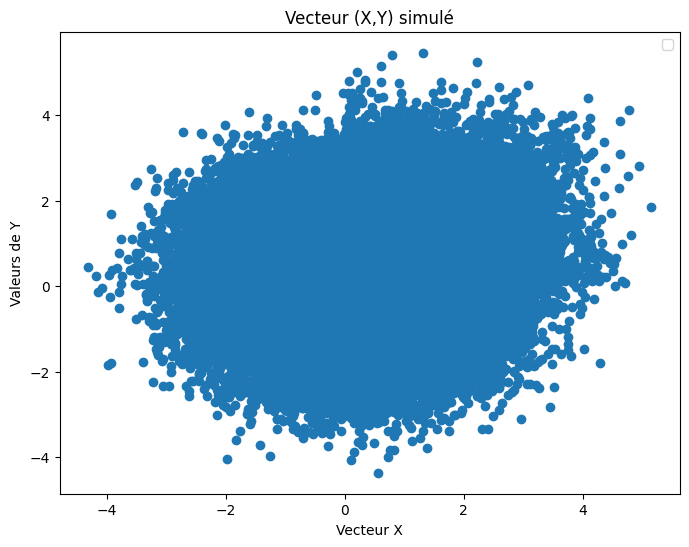

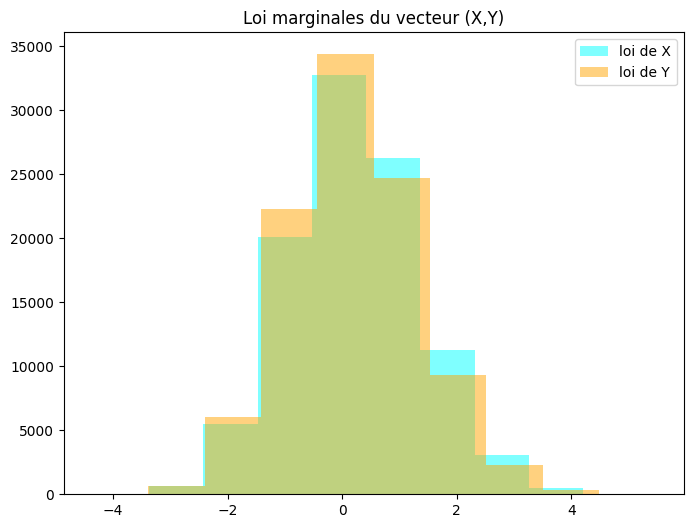

In [38]:
n = 10**5  #nombre de simulations
Mp, Mq = np.sqrt(2 / np.pi) * np.exp(2), np.sqrt(2 / np.pi) * np.exp(2)
p, q = stats.norm(), stats.norm()
pH, qH = stats.expon(scale = 1/2), stats.expon(scale = 1/2)

valeurs_de_X = []
valeurs_de_Y = []
for _ in tqdm(range(n)):
    X, Y = RejectionCoupling_application(p, q, pH, qH, Mp, Mq)
    valeurs_de_X.append(X)
    valeurs_de_Y.append(Y)

plt.figure(figsize=(8,6))
plt.scatter(valeurs_de_X, valeurs_de_Y)
plt.xlabel("Vecteur X")
plt.ylabel("Valeurs de Y")
plt.title("Vecteur (X,Y) simulé")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.hist(valeurs_de_X, color = "cyan", alpha = 0.5, label = "loi de X")
plt.hist(valeurs_de_Y, color = "orange", alpha = 0.5,  label = "loi de Y")
plt.title("Loi marginales du vecteur (X,Y)")
plt.legend()
plt.show()

## Algorithme de "Reflection Coupling"

Nous nous concentrons maintenant sur le cas spécial important du couplage de distributions gaussiennes d-dimensionnelles avec des moyennes et des covariances différentes.

On commence par implémenter l'algorithme "Reflection maximal coupling" : 

In [58]:
def ReflectionCoupling(a, b, sigma): 
    """  ReflectionCoupling : méthode de Bou-Rabee et al. (2020)
    Initialisation : deux vecteurs a et b représentant les moyennes des distributions à coupler, 
    et une matrice de covariance sigma.

    Cet algorithme permet de coupler deux distributions multivariées en ajustant les vecteurs aléatoires X et Y pour 
    qu'ils respectent les moyennes et les covariances spécifiées par les vecteurs a et b et la matrice de covariance sigma.
    """
    d = sigma.shape[0]
    sigma_inverse = linalg.inv(sigma)
    z = np.dot(linalg.sqrtm(sigma_inverse), (a - b))
    e = z / linalg.norm(z)
    multivariate_normal = stats.multivariate_normal(mean = np.zeros(d), cov = np.eye(d))
    X, U = multivariate_normal.rvs(), npr.uniform()
    if multivariate_normal.pdf(X) * U < multivariate_normal.pdf(X + z):
        Y = X + z
    else:
        Y = X - 2 * np.dot(X, e) * e
    X2, Y2 = a + np.dot(linalg.sqrtm(sigma), X), b + np.dot(linalg.sqrtm(sigma), Y)
    return X2, Y2

### Simulation.

In [59]:
def generer_matrice_inversible(d):
    """ 
    Permet de générer une matrice aléatoire de taille d, inversible.
    """
    matrice = np.random.rand(d, d)
    if np.linalg.matrix_rank(matrice) == d:
        return matrice

Matrice aléatoire :
 [[0.87, 1.  , 0.04, 0.44, 0.86],
 [0.27, 0.03, 0.84, 0.07, 0.1 ],
 [0.08, 0.57, 0.11, 0.2 , 0.4 ],
 [0.97, 0.82, 0.63, 0.62, 0.2 ],
 [0.53, 0.01, 0.24, 0.75, 0.53]]


  0%|          | 0/100000 [00:00<?, ?it/s]

/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_12480/23915433.py:12: RuntimeWarning: invalid value encountered in true_divide
  e = z / linalg.norm(z)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_multivariate.py:430: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.asarray(x, dtype=float)
100%|██████████| 100000/100000 [01:06<00:00, 1507.01it/s]
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6794: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


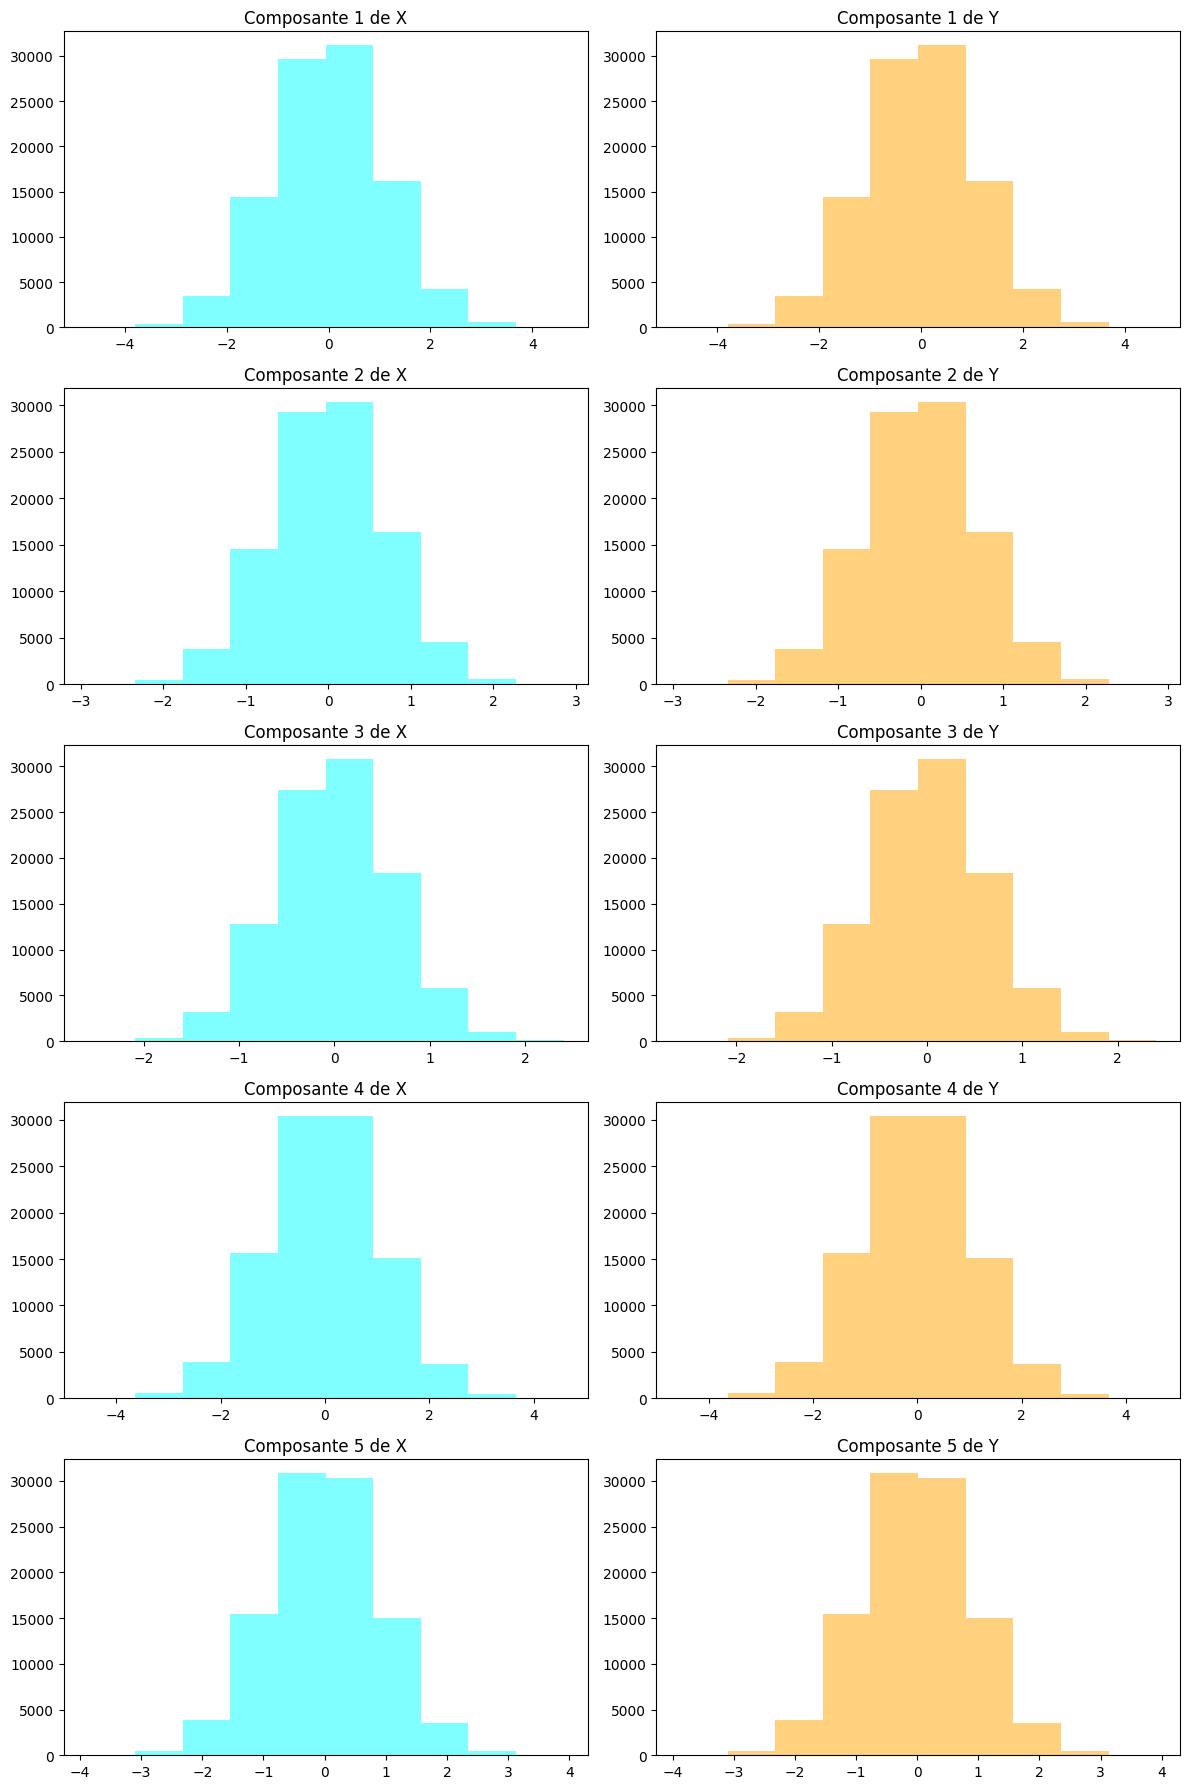

/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


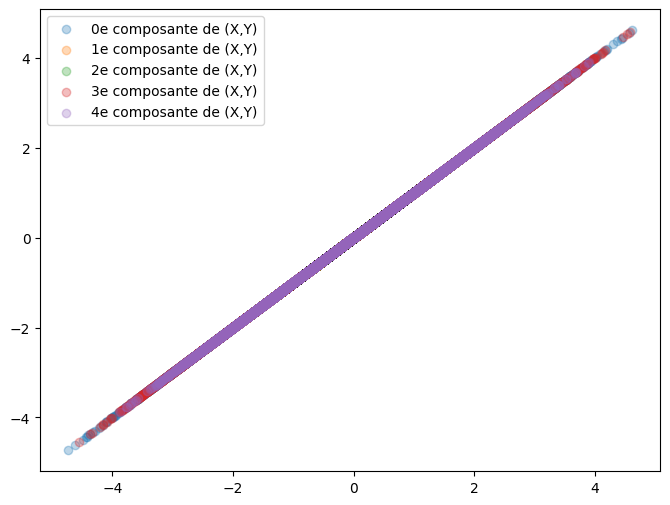

In [68]:
n = 10**5  #nombre de simulations
a = np.zeros(5)
b = np.zeros(5)
sigma = generer_matrice_inversible(5)
print("Matrice aléatoire :\n", np.array2string(sigma, precision=2, separator=', ', suppress_small=True))

valeurs_de_X = []
valeurs_de_Y = []
for _ in tqdm(range(n)):
    X, Y = ReflectionCoupling(a, b, sigma)
    valeurs_de_X.append(X)
    valeurs_de_Y.append(Y)

valeurs_de_X = np.array(valeurs_de_X)
valeurs_de_Y = np.array(valeurs_de_Y)
fig, axs = plt.subplots(5, 2, figsize=(12, 18))

for i in range(5):
    axs[i, 0].hist(valeurs_de_X[:,i], color="cyan", alpha=0.5)
    axs[i, 0].set_title(f"Composante {i+1} de X")

    # Affichage de l'histogramme de la i-ème composante de Y
    axs[i, 1].hist(valeurs_de_Y[:,i], color="orange", alpha=0.5)
    axs[i, 1].set_title(f"Composante {i+1} de Y")

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
for i in range(5):
    plt.scatter(valeurs_de_X[:,i], valeurs_de_Y[:,i], label = f"{i}e composante de (X,Y)", alpha = 0.3)
plt.legend()
plt.show()

## Application 1 : Liaison des queues des distributions gaussiennes

Soient $X \sim \mathcal{N}(0,1), Y \sim \mathcal{N}(0,1)$.

Introduisons $X_{\mu} = X | X > \mu$ de densité par rapport à la mesure de lebesgue $ p_{\mu}$ et $Y_{\eta} = Y | Y > \eta$ de densité par rapport à la mesure de lebesgue $ q_{\eta}$.

Lorsque $\mu , \eta $ deviennent grand, on ne peut plus utliser la méthode d'inversion pour simuler $p$ et $q$, nous devons voir recours à la méthode d'échantillonnage par rejet. 

On utilise une loi exponentielle translatée comme proposition : $\text{Exp} (x; m, \lambda) = \lambda e^{- \lambda (x-m)} \textbf{1} (x \ge m)$.

Sans pertes de généralités, on suppose que $ \eta > \mu $.

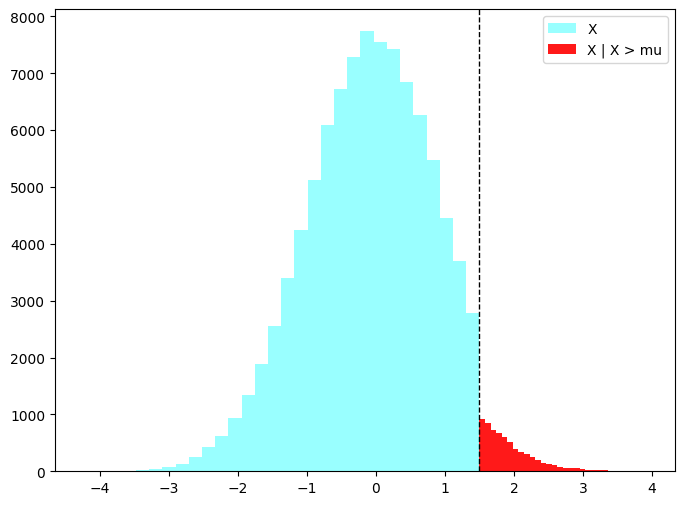

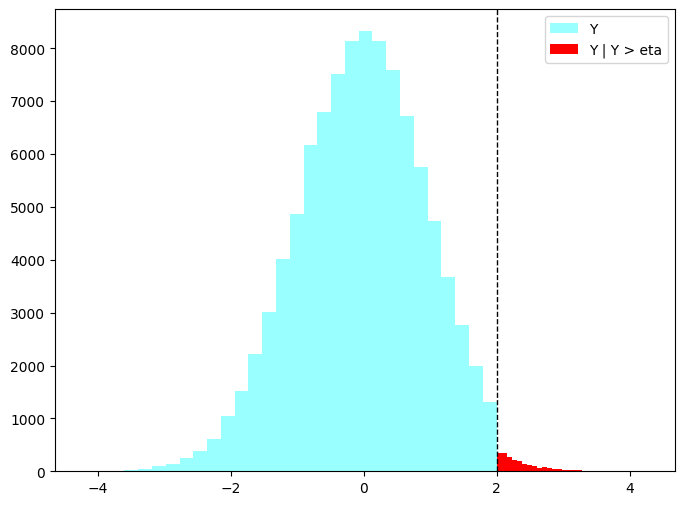

In [26]:
n = 10**5
mu, eta = 1.5, 2
X = npr.normal(0, 1, size=n)
X_filtre = X[X<=mu]
X_mu = X[X>mu]
Y = npr.normal(0, 1, size=n)
Y_filtre = Y[Y<=eta]
Y_eta = Y[Y>eta]

plt.figure(figsize=(8,6))
plt.hist(X_filtre, bins = 30, label = "X", color = "cyan", alpha = 0.4)
plt.hist(X_mu, bins = 30, label = "X | X > mu", color = "red", alpha = 0.9)
plt.axvline(x=mu, color='k', linestyle='--', linewidth=1)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.hist(Y_filtre, bins = 30, label = "Y", color = "cyan", alpha = 0.4)
plt.hist(Y_eta, bins = 30, label = "Y | Y > eta", color = "red")
plt.axvline(x=eta, color='k', linestyle='--', linewidth=1)
plt.legend()
plt.show()

In [2]:
coupling_gaussian_distributions(5,6)

NameError: name 'x' is not defined

## Application 3 : Coupled Gibbs sampling

On considère $ p(x,y) \propto \text{exp} ( - \frac{1}{2} (x ^{T} x . y^{T}y + x ^{T} x + y^{T}y )) $ , $ x, y \in \mathbb{R}^{d}$. 

Après calcul, on trouve que : 

- $p_{x|y}(x) = \mathcal{N}(x ; 0, P_y)$ où $P_y = \frac{1}{1 + y^{T}y} I_d$

- $p_{y|x}(y) = \mathcal{N}(y ; 0, P_x)$ où $P_x = \frac{1}{1 + x^{T}x} I_d$

Grâce à cela, nous pouvons utiliser l'algorithme de Gibbs pour simuler un vecteur aléatoire de loi $p(x,y)$ : 

Rappel : 

L'idée de l'algorithme de Gibbs est de rejouer une par une les coordonnées du vecteur selon la loi conditionnelle sachant toutes les autres.

In [85]:
def coupled_gibbs_sampling(initialisation, n_iter):
    """  ReflectionCoupling : simuler p(x, y) en utilisant Gibbs Robert et Casella, 2004, Ch. 4

    --------
    Paramètres :
    initialisation : deux vecteurs x et y de taille d.
    """
    d = len(initialisation[0])  #dimension

    # On commence par initialiser nos vecteurs
    X, Y = [], []
    X.append(initialisation[0])
    Y.append(initialisation[1])
    for _ in range(n_iter):
        #simuler p(x|y)
        P_y = (1 / 1 + linalg.norm(Y[-1]) ** 2) ** 2
        x = stats.multivariate_normal(np.zeros(d) ** P_y).rvs()

        #simuler p(y|x)
        P_x = (1 / 1 + linalg.norm(x) ** 2) ** 2
        y = stats.multivariate_normal(np.zeros(d) ** P_x).rvs()

        X.append(x)
        Y.append(y)
    return X, Y

/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6794: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


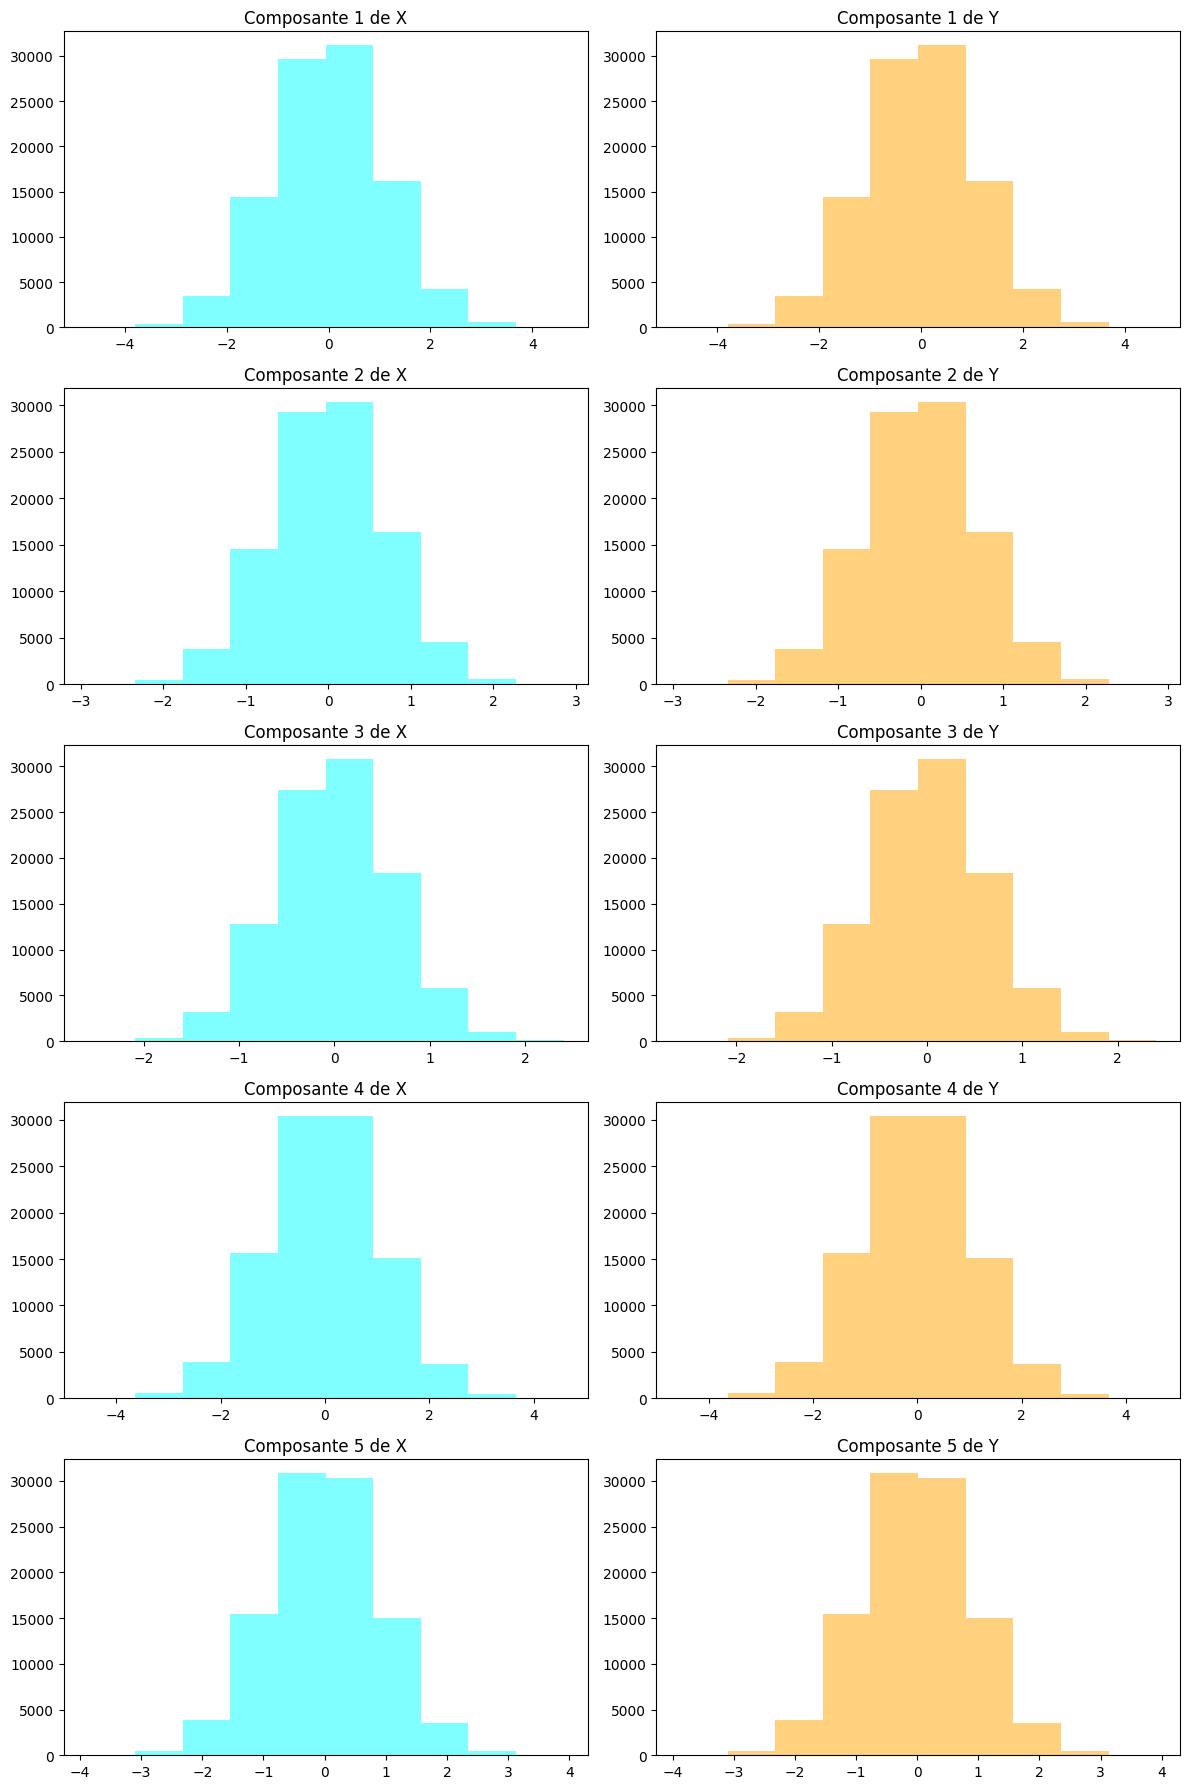

/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


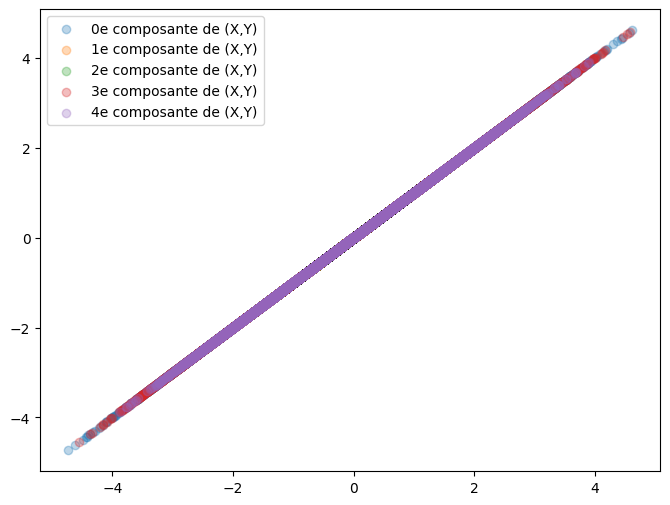

In [86]:
n = 10**4
d = 5
initialisation = np.zeros(d), np.ones(d)
X, Y = coupled_gibbs_sampling(initialisation, n)

X = np.array(X)
Y = np.array(Y)
fig, axs = plt.subplots(5, 2, figsize=(12, 18))

for i in range(5):
    axs[i, 0].hist(valeurs_de_X[:,i], color="cyan", alpha=0.5)
    axs[i, 0].set_title(f"Composante {i+1} de X")

    # Affichage de l'histogramme de la i-ème composante de Y
    axs[i, 1].hist(valeurs_de_Y[:,i], color="orange", alpha=0.5)
    axs[i, 1].set_title(f"Composante {i+1} de Y")

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
for i in range(5):
    plt.scatter(valeurs_de_X[:,i], valeurs_de_Y[:,i], label = f"{i}e composante de (X,Y)", alpha = 0.3)
plt.legend()
plt.show()

## Algorithme de Thorisson 

Cette approche est valide pour construire une distribution jointe (couplage) pour $(X,Y)$ telle que $X \sim p$, $Y \sim q$ et $ \mathbb{P} (X=Y)$ avec une probabilité élevée.

### **Contexte** : 

Pour réaliser un couplage maximal, on cherche $X^* \sim p(\cdot | X_t)$ et $Y^* \sim p(\cdot | Y_t)$ de manière à maximiser $P(X^* = Y^*)$ parmi l'ensemble des couplages possibles. 
Pour ce faire, si $ p(\cdot | X_t)$ et $ p(\cdot | Y_t)$ sont des distributions gaussiennes de mêmes covariances, alors un algorithme explicite existe.

En revanche, si les covariances sont différentes, on doit se résoudre à utiliser un algorithme d'acceptation-rejet tel que l'algorithme de Thorisson. 

De plus, un couplage maximal vérifie $P(X = Y) = \int_{0}^{1} \min(p(x),q(x))\, dx $. 

Le problème dans ce cas est que la variance du temps d'exécution tend vers l'infini lorsque la loi marginale de X tend vers celle de Y. Or, nous cherchons à contrôler cette variance, c'est pourquoi une approche alternative consiste à échantillonner $X^* \text {et } Y^*$ sous optimaux pour le problème mais avec un contrôle sur le temps d'exécution. 

Dans ce cas, on préfère échantillonner de manière à obtenir  $P(X = Y) = C\int_{0}^{1} \min(p(x),q(x))\, dx $ avec $ 0 < C < 1$ une constante qui contrôle la sous optimalité des distributions échantillonnées. 

### **Algorithme de Thorisson :**

Cet algorithme repose sur le principe d'acceptation-rejet pour un couplage, en tenant compte du prérequis de maximisation de $P(X=Y)$. Pour cela, on choisit d'échantillonner $X \sim p$ comme loi de proposition et on va "fixer" la loi de $X$ afin de bâtir $Y$ tel qu'il maximise le couplage. 

Dans un premier temps, on procède donc à un algorithme d'acceptation-rejet "classique" car on simule de manière uniforme la loi cible de $Y$ à partir de l'aire sous la densité de la propositionnelle $X$. 

- Si $ U < min(\frac{p(x)}{q(x)},C)$, alors on assigne $X \text{ à } Y$.
Cela correspond au fait que si $p(x)$ est relativement grand par rapport à $q(x)$, alors $X$ a plus de chances d'être choisi par rapport à $Y$. 

Ainsi, afin de maximiser le couplage tel que ${X=Y}$, si la distribution de $X$ est dominante, on assigne $X \text{ à } Y$.

- Sinon, on est dans le cas où $p(x)$ n'est pas relativement grand par rapport à $q(x)$ ou bien $ q(x)$ est grand par rapport à $p(x)$. Dans ce cas, $Y$ a plus de chances d'être choisi que $X$, c'est pourquoi on procède à nouveau à une étape d'acceptation-rejet avec $q(z)$ comme propositionnelle car on cherche à accepter plutôt selon la densité $q$. Dans ce cas, si $q(z)$ est relativement grand par rapport à $C*p(z)$, on a plus de chances que $Y$ soit accepté donc afin d'aboutir à un couplage, on assigne $Z$ à $Y$. 

Cet algorithme assure donc que lorsque $p$ est relativement grand devant $q$, on maximise $P(X=Y)$ car on assigne les mêmes valeurs à $X$ et $Y$. 

Sinon, lorsque $q$ est relativement grand devant $p$, on s'assure de choisir ces échantillons avec une probabilité proportionnelle à $\frac{p(z)}{q(z)}$. 

Cette méthode consiste donc en un équilibre entre échantilloner à partir de la densité cible $p$ et la propositionnelle $q$ : en fixant l'une des deux densités, on peut contrôler le couplage de telle sorte que l'autre densité marginale soit proche de la première en couplant. 

### **Le  rôle de $C$ :** 

- Si $C$ est petit, il est plus dur pour un échantillon d'être accepté, donc on favorise dans l'algorithme les échantillons où $p \approx q$ de manière à simplifier le couplage. 

- Si $C$ est grand, le taux d'acceptation est plus élevé (donc on émet moins de restriction sur le couplage). Mais dans ce cas, la variance du temps d'exécution augmente considérablement. 


In [3]:
def ThorissonCoupling(p, q, C):
    X = p.rvs()
    U = np.random.uniform()
    if U < min(q.pdf(X) / p.pdf(X), C): 
        Y = X
    else: 
        A = 0
        while A!=1: 
            U = np.random.uniform()
            Z = q.rvs()
            if U > min(1, C * (p.pdf(Z) / q.pdf(Z))):
                A = 1
            Y = Z
    return X,Y

100%|██████████| 10000/10000 [00:04<00:00, 2109.09it/s]
/var/folders/p2/mz39_3ld1931_8d18wv6l6jh0000gn/T/ipykernel_25979/425650677.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(couple[:,0], couple[:,1], label = f'C = {C}', cmap='viridis')
100%|██████████| 10000/10000 [00:04<00:00, 2053.89it/s]


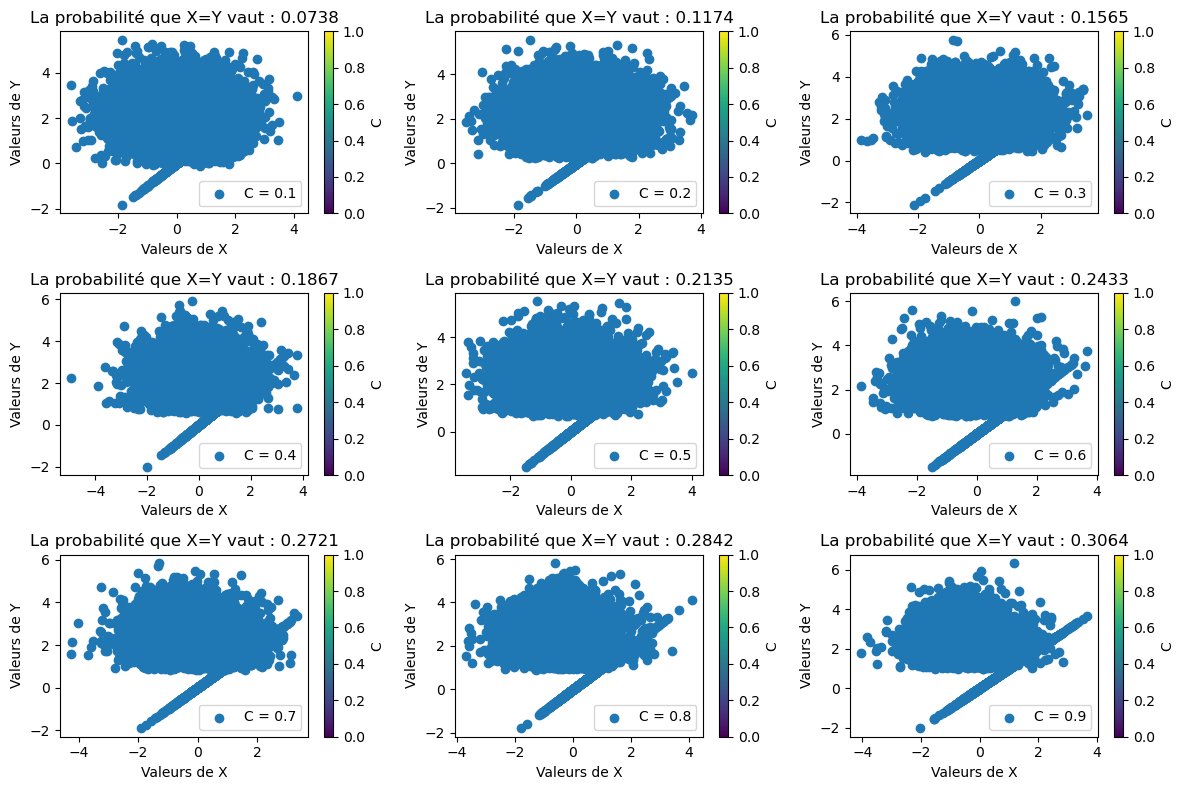

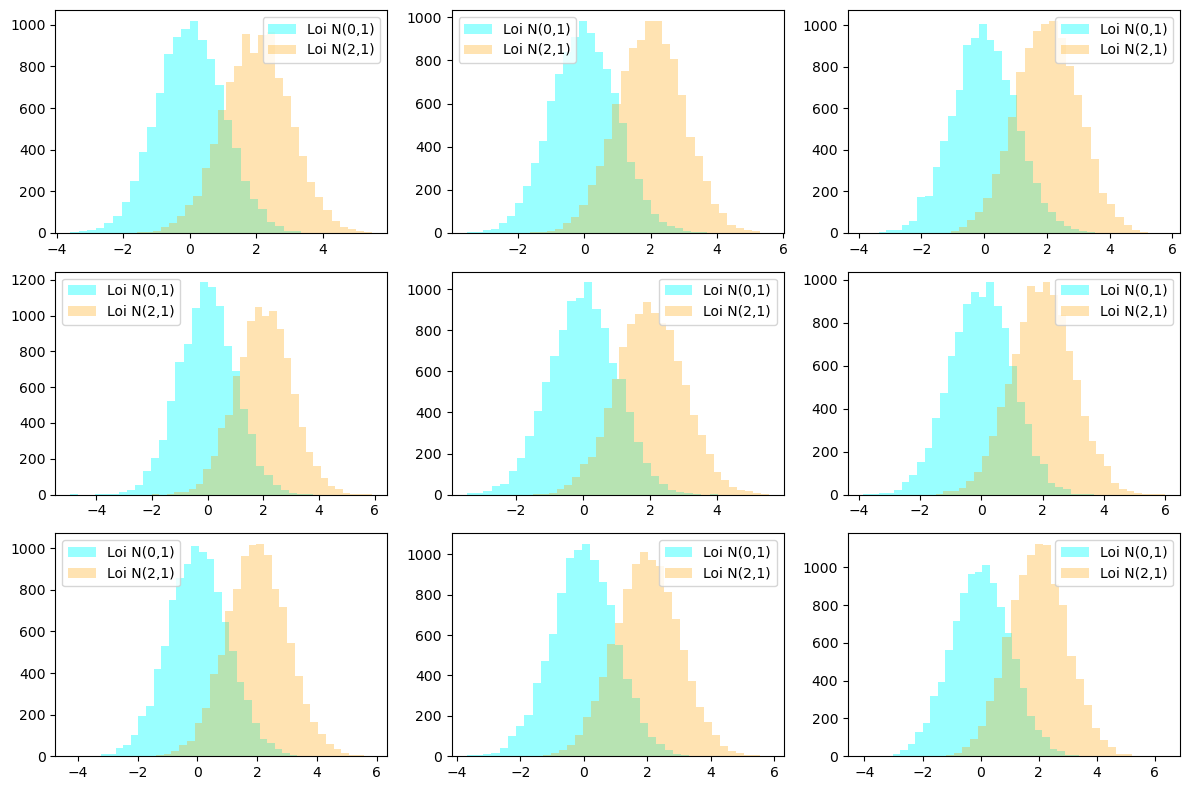

In [6]:
n = 10**4

def create_couple(C):
    c = []
    for _ in tqdm(range(n)):
        p = stats.norm(0, 1)  
        q = stats.norm(2, 1)  
        c.append(ThorissonCoupling(p, q, C))
    c = np.array(c)
    return c

liste_couples = []
temps_exec = []
plt.figure(figsize=(12, 8))
for i, C in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], start=1):
    debut = time.time()
    couple = create_couple(C)
    fin = time.time()
    temps_exec.append(fin-debut)
    liste_couples.append(couple)
    plt.subplot(3, 3, i)
    plt.xlabel("Valeurs de X")
    plt.ylabel("Valeurs de Y")
    proba = np.sum(couple[:,0]==couple[:,1]) / len(couple)
    plt.title(f"La probabilité que X=Y vaut : {proba}")
    plt.scatter(couple[:,0], couple[:,1], label = f'C = {C}', cmap='viridis')
    plt.colorbar(label='C')
    plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
for i, couple in enumerate(liste_couples, start = 1):
    plt.subplot(3, 3, i)
    loi1 = couple[:,0]
    loi2 = couple[:,1]
    plt.hist(loi1, bins=30, label = "Loi N(0,1)", color ="cyan", alpha = 0.4)
    plt.hist(loi2, bins=30, label = "Loi N(2,1)", color ="orange", alpha = 0.3)
    plt.legend()
plt.tight_layout()
plt.show()


In [16]:
C = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i in range(len(C)):
    print("Temps d'exécution de Thorisson pour C = ",C[i],":",temps_exec[i],"s." )

Temps d'exécution de Thorisson pour C =  0.1 : 4.743856191635132 s.
Temps d'exécution de Thorisson pour C =  0.2 : 4.71229100227356 s.
Temps d'exécution de Thorisson pour C =  0.3 : 4.783577919006348 s.
Temps d'exécution de Thorisson pour C =  0.4 : 4.8417651653289795 s.
Temps d'exécution de Thorisson pour C =  0.5 : 4.824237823486328 s.
Temps d'exécution de Thorisson pour C =  0.6 : 4.844713926315308 s.
Temps d'exécution de Thorisson pour C =  0.7 : 4.804152965545654 s.
Temps d'exécution de Thorisson pour C =  0.8 : 4.822035074234009 s.
Temps d'exécution de Thorisson pour C =  0.9 : 4.870844125747681 s.


On observe bien ici que $P(X=Y)$ croît avec $C$. Cela résulte de l'acceptation-rejet qui est moins contraignante pour $C$ grand. Dans ce cas, on accepte plus d'échantillons couplés selon la diagonale. 

Le temps d'exécution augmente également avec $C$, comme le prévoit l'article. Ce qui justifie le fait d'utiliser $C$ comme facteur de sous-optimalité pour le couplage. 